In [1]:
%matplotlib inline

# 自動駕駛街景分割(cntk)

<img src="../Data/autodrive_train/orign_images/0001TP_006750.png",width=480,height=360>
<img src="../Data/autodrive_train/masks/0001TP_006750_L.png",width=480,height=360>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pylab
import PIL
from PIL import Image
import glob
import threading
import random
import math
import datetime
import cntk as C
import numpy as np
from cntk.ops import *
from cntk.layers import *
from cntk.initializer import *
from cntk.logging import *
from cntk.train import *
from cntk.learners import *
from cntk.losses import *
from cntk.device import *

# 是否使用GPU
is_gpu = True
if is_gpu:
    try_set_default_device(gpu(0))
else:
    try_set_default_device(cpu())

In [3]:
images = glob.glob('../Data/autodrive_train/orign_images/' + '*.png')
labels = ['../Data/autodrive_train/masks/' + os.path.basename(i)[:-4] + '_L.png' for i in images]
print(len(images))
print(images[:5])

701
['../Data/autodrive_train/orign_images\\0001TP_006690.png', '../Data/autodrive_train/orign_images\\0001TP_006720.png', '../Data/autodrive_train/orign_images\\0001TP_006750.png', '../Data/autodrive_train/orign_images\\0001TP_006780.png', '../Data/autodrive_train/orign_images\\0001TP_006810.png']


In [4]:
print(open("label_colors.txt").readlines())

['Void\t0 0 0\n', 'Building\t128 0 0\n', 'grass\t0 128 0\n', 'Tree\t128 128 0\n', 'cow\t0 0 128\n', 'horse\t128 0 128\n', 'sheep\t0 128 128\n', 'Sky\t128 128 128\n', 'mountain\t64 0 0\n', 'aeroplane\t192 0 0\n', 'water\t64 128 0\n', 'face\t192 128 0\n', 'Car\t64 0 128\n', 'Archway\t192 0 128\n', 'flower\t64 128 128\n', 'SignSymbol\t192 128 128\n', 'bird\t0 64 0\n', 'book\t128 64 0\n', 'chair\t0 192 0\n', 'motorbike\t128 192 0\n', 'person\t0 64 128\n', 'Road\t128 64 128\n', 'cat\t0 192 128\n', 'dog\t128 192 128\n', 'Pedestrian\t64 64 0\n', 'boat\t192 64 0\n', 'Wall\t64 192 0\n', 'VegetationMisc\t192 192 0\n', 'Fence\t64 64 128\n', 'Train\t192 64 128\n', 'ParkingBlock\t64 192 128\n', 'Column_Pole\t192 192 128\n', 'TrafficCone\t0 0 64\n', 'unused\t128 0 64\n', 'Bridge\t0 128 64\n', 'Misc_Text\t128 128 64\n', 'Sidewalk\t0 0 192\n', 'LaneMkgsDriv\t128 0 192\n', 'Bicyclist\t0 128 192\n', 'RoadShoulder\t128 128 192\n', 'Tunnel\t64 0 64\n', 'LaneMkgsNonDriv\t192 0 64\n', 'Animal\t64 128 64\n',

In [5]:
def parse_code(l):
    if len(l.strip().split("\t")) == 2:
        a, b = l.replace('\t\t','\t').strip().split("\t")
        return tuple(int(i) for i in b.split(' '))[::-1], a

label_codes, label_names = zip(*[parse_code(l) for l in open("label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)

for i in range(len(label_codes)):
    print(str(label_codes[i])+' '+label_names[i])

(0, 0, 0) Void
(0, 0, 128) Building
(0, 128, 0) grass
(0, 128, 128) Tree
(128, 0, 0) cow
(128, 0, 128) horse
(128, 128, 0) sheep
(128, 128, 128) Sky
(0, 0, 64) mountain
(0, 0, 192) aeroplane
(0, 128, 64) water
(0, 128, 192) face
(128, 0, 64) Car
(128, 0, 192) Archway
(128, 128, 64) flower
(128, 128, 192) SignSymbol
(0, 64, 0) bird
(0, 64, 128) book
(0, 192, 0) chair
(0, 192, 128) motorbike
(128, 64, 0) person
(128, 64, 128) Road
(128, 192, 0) cat
(128, 192, 128) dog
(0, 64, 64) Pedestrian
(0, 64, 192) boat
(0, 192, 64) Wall
(0, 192, 192) VegetationMisc
(128, 64, 64) Fence
(128, 64, 192) Train
(128, 192, 64) ParkingBlock
(128, 192, 192) Column_Pole
(64, 0, 0) TrafficCone
(64, 0, 128) unused
(64, 128, 0) Bridge
(64, 128, 128) Misc_Text
(192, 0, 0) Sidewalk
(192, 0, 128) LaneMkgsDriv
(192, 128, 0) Bicyclist
(192, 128, 128) RoadShoulder
(64, 0, 64) Tunnel
(64, 0, 192) LaneMkgsNonDriv
(64, 128, 64) Animal
(64, 128, 192) Child
(192, 0, 64) CartLuggagePram
(192, 0, 192) MotorcycleScooter
(192

In [6]:
img_h =64
img_w = 64
num_classes =len(label_codes)


#開啟圖片，並且縮放至64*64(原圖是960*720)
def open_image(img):
    x=np.array(Image.open(img).resize((img_h,img_w), Image.NEAREST))
    x = x.astype(np.float32).transpose(2,0,1)
    x = np.ascontiguousarray(x)[::-1]
    return x

imgs = np.stack([open_image(i) for i in images])
print(imgs.shape)

lbs = np.stack([open_image(l) for l in labels])
print(lbs.shape)

(701, 3, 64, 64)
(701, 3, 64, 64)


In [7]:
#將圖片向量除以255，讓數值介於0~1之間
imgs = imgs/255.

#計算圖片的平均值與標準差
mean = imgs.mean()
std = imgs.std()
print('平均值:{0},標準差:{1}'.format(mean, std))

#圖片根據平均值與標準差正歸化
imgs-=imgs.mean()
imgs/=imgs.std()

平均值:0.40013885498046875,標準差:0.3020400106906891


In [8]:
#產生索引對類別色彩之間的轉換
code2id = {v: k for k, v in enumerate(label_codes)}
id2code = {k: v for k, v in enumerate(label_codes)}
print(len(label_codes))
num_class=len(label_codes)
code2id

50


{(0, 0, 0): 0,
 (0, 0, 64): 8,
 (0, 0, 128): 1,
 (0, 0, 192): 9,
 (0, 64, 0): 16,
 (0, 64, 64): 24,
 (0, 64, 128): 17,
 (0, 64, 192): 25,
 (0, 128, 0): 2,
 (0, 128, 64): 10,
 (0, 128, 128): 3,
 (0, 128, 192): 11,
 (0, 192, 0): 18,
 (0, 192, 64): 26,
 (0, 192, 128): 19,
 (0, 192, 192): 27,
 (64, 0, 0): 32,
 (64, 0, 64): 40,
 (64, 0, 128): 33,
 (64, 0, 192): 41,
 (64, 64, 0): 48,
 (64, 64, 128): 49,
 (64, 128, 0): 34,
 (64, 128, 64): 42,
 (64, 128, 128): 35,
 (64, 128, 192): 43,
 (128, 0, 0): 4,
 (128, 0, 64): 12,
 (128, 0, 128): 5,
 (128, 0, 192): 13,
 (128, 64, 0): 20,
 (128, 64, 64): 28,
 (128, 64, 128): 21,
 (128, 64, 192): 29,
 (128, 128, 0): 6,
 (128, 128, 64): 14,
 (128, 128, 128): 7,
 (128, 128, 192): 15,
 (128, 192, 0): 22,
 (128, 192, 64): 30,
 (128, 192, 128): 23,
 (128, 192, 192): 31,
 (192, 0, 0): 36,
 (192, 0, 64): 44,
 (192, 0, 128): 37,
 (192, 0, 192): 45,
 (192, 128, 0): 38,
 (192, 128, 64): 46,
 (192, 128, 128): 39,
 (192, 128, 192): 47}

In [9]:
#產生索引對類別色彩之間的轉換
code2id = {v: k for k, v in enumerate(label_codes)}
id2code = {k: v for k, v in enumerate(label_codes)}
label_colours = np.asarray(label_codes)
failed_code = len(label_codes) + 1
n, ch,r, c = imgs.shape

#轉換單張標籤為mask(3*64*64->50*64*64)
def conv_one_label(b_label,num_class=50):
    res = np.zeros((num_class, b_label.shape[1],b_label.shape[2]), 'float32')
    for j in range(b_label.shape[1]):
        for k in range(b_label.shape[2]):
            color=tuple(b_label[:,j,k].tolist())
            if color in code2id:
                try:
                    res[code2id[color], j, k] = 1
                except Exception as e:
                    print(e)
                    print(code2id[color])
                    print(color)
                    res[0, j, k] = 1
            else:
                res[0, j, k] = 1
    return res

#將一個批次做轉換
def conv_all_labels(b_label):
    lblist = []
    for i in range(b_label.shape[0]):
        ls = conv_one_label(b_label[i])
        lblist.append(ls)
    return np.asarray(lblist)

#將向量轉圖片
def array2img(arr: np.ndarray):
    sanitized_img =arr
    if len(arr.shape) > 2:
        if arr.shape[0]>1:
            arr = arr[::-1]
        sanitized_img = np.maximum(0, np.minimum(255, np.transpose(arr, (1, 2, 0))))
        if arr.shape[0]==1:
            sanitized_img =np.squeeze(sanitized_img,-1)
        img = Image.fromarray(sanitized_img.astype(np.uint8))
        return img
    elif  len(arr.shape) == 2:
        img = Image.fromarray(arr.astype(np.int8))
        return img

#將mask轉RGB圖片(50*64*64=>3*64*64)
def decode_labels(masks, num_classes=50):
    global img_w, img_h
    result = []
    for batch in range(masks.shape[0]):
        decode_map = masks[batch]
        decode_map = np.argmax(decode_map, 0).astype(np.float32)
        color_img = np.zeros((img_h, img_w, 3), dtype=np.float32)# * 192
        for k in range(num_classes):
            if k > 0:
                color_img[decode_map == k] = label_colours[k]
        result.append(color_img.transpose(2, 0, 1))
    return np.asarray(result)

#把圖片並列列印出來
def tile_rgb_images(pred, label, truth, row=3, col=3):
    fig = pylab.gcf()
    fig.set_size_inches(col * 2, row * 2)
    pylab.clf()
    pylab.ioff()  # is not None:
    for m in range(row * col):
        pylab.subplot(row, col, m + 1)
        if m % 3 == 0:
            if pred.shape[0] == 1:
                pred = pred[0]
            img = array2img(pred[int(m / 3)]).resize((120,90))
        elif m % 3 == 1:
            if label.shape[0] == 1:
                label = label[0]
            img = array2img(label[int((m - 1) / 3)]).resize((120,90))
        else:
            if truth.shape[0] == 1:
                truth = truth[0]
            img = array2img((truth[int((m - 2) / 3)] * std + mean) * 255).resize((120,90))
        pylab.imshow(img, interpolation="nearest", animated=True)
        pylab.axis("off")

In [10]:
idx=0
idxs=np.arange(len(imgs))
np.random.shuffle(idxs)

def get_next_minibatch(minibatch_size=8):
    global idx,idxs
    features=[]
    masks=[]
    while len(features)<minibatch_size:
        features.append(imgs[idxs[idx]])
        masks.append(lbs[idxs[idx]])
        idx+=1
        if idx>=len(imgs)-1:
            idx=0
            np.random.shuffle(idxs)
    return np.asarray(features),conv_all_labels(np.asarray(masks))
        
    

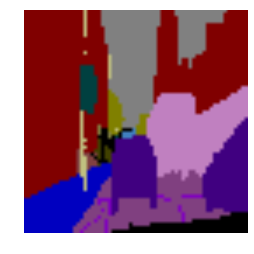

In [11]:
label=array2img(lbs[0])
plt.axis('off')
plt.imshow(label)

(50, 64, 64)
(1, 3, 64, 64)


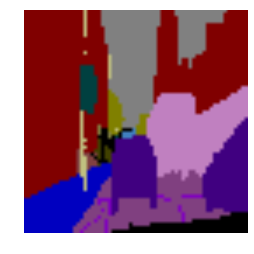

In [12]:
mask=conv_one_label(lbs[0],num_class)
print(mask.shape)
rgb_label=decode_labels(np.asarray([mask]),num_class)
print(rgb_label.shape)
plt.axis('off')
plt.imshow(array2img(rgb_label[0]))

In [13]:
minibatch_size =8
num_epochs = 10
learning_rate = 0.000125  # 學習速率

input_var = input_variable((3, img_h, img_w), dtype=np.float32, dynamic_axes=Axis.default_batch_axis())
label_var = input_variable((num_classes, img_h, img_w), dtype=np.float32, dynamic_axes=Axis.default_batch_axis())



In [14]:
b_img, b_label = get_next_minibatch(minibatch_size)
print(b_img.shape)
print(b_label.shape)

(8, 3, 64, 64)
(8, 50, 64, 64)


![autodrive](../Images/tiramisu.jpg)

In [15]:

def conv_bn(filter_size, num_filters, strides=(1, 1), init=he_normal(), activation=None, pad=True, bias=False,drop_rate=0.0,name=''):
    def apply_x(x):
        c = Convolution(filter_size, num_filters, activation=None, init=init, pad=pad, strides=strides,bias=bias,name=name)(x)
        r =BatchNormalization()(c)
        if drop_rate>0:
            r = dropout(r, drop_rate)
        if activation==None:
            return r
        else:
            return activation(r)
    return apply_x


def conv_bn_relu(filter_size, num_filters, strides=(1, 1), init=he_normal(), activation=relu, pad=True, drop_rate=0.0,name=''):
    return conv_bn(filter_size, num_filters, strides, init, activation=activation, pad=pad)


def UpSampling2D(x):
    xr = C.reshape(x, (x.shape[0], x.shape[1], 1, x.shape[2], 1))
    xx = C.splice(xr, xr, axis=-1) # axis=-1 refers to the last axis
    xy = C.splice(xx, xx, axis=-3) # axis=-3 refers to the middle axis
    r = C.reshape(xy, (x.shape[0], x.shape[1] * 2, x.shape[2] * 2))
    return r

#DB
def dense_block(x, depth, growth_rate, drop_rate=0.0, activation=leaky_relu):
    for i in range(depth):
        b = conv_bn((3, 3), growth_rate, init=he_uniform(), drop_rate=drop_rate, activation=activation)(x)
        x = splice(x, b, axis=0)
    return  x



def transition_down(x,activation=leaky_relu, drop_rate=0):
    n_filters=x.shape[0]
    x =  conv_bn((3, 3), n_filters*2,strides=2,pad=True, init=he_uniform(), drop_rate=drop_rate, activation=activation)(x)
    x = conv_bn((1, 1), n_filters, (1, 1), pad=True, drop_rate=drop_rate, activation=activation)(x)
    return x

#TD
def down_path(x, depths, growth_rate, drop_rate=0, activation=leaky_relu):
    skips = []
    n = len(depths)
    for i in range(n):
        x = dense_block(x, depths[i], growth_rate, drop_rate=drop_rate, activation=activation)
        skips.append(x)
        if i<n-1:
            n_filters=depths[i]*growth_rate
            x = transition_down(x, activation=leaky_relu)
    return skips, x


def transition_up(x, n_filters,activation=leaky_relu):
    x =UpSampling2D(x)
    x = conv_bn((1, 1), n_filters, (1, 1), pad=True, drop_rate=0, activation=activation)(x)
    return x

#TU
def up_path(x, skips, depths, growth_rate,  drop_rate=0, activation=leaky_relu):
    n = len(depths)
    for i in range(n):
        n_filters=depths[i]*growth_rate
        x = transition_up(x, n_filters, activation=activation)
        x = splice(x, skips[i], axis=0)
        x= dense_block(x, depths[i], growth_rate, drop_rate=0, activation=activation)
    return x


def reverse(a): return list(reversed(a))


def fc_dense(depths, growth_rate=16, n_channel_start=32, n_classes=21, drop_rate=0.2, activation=leaky_relu):
    depths = list(depths)
    def apply_x(x):
        x = conv_bn((3, 3), n_channel_start, pad=True, strides=1, init=he_normal(0.02), activation=activation, bias=True)( x)
        skips, x = down_path(x, depths, growth_rate, drop_rate=drop_rate, activation=leaky_relu)
        x= up_path(x, reverse(skips[:-1]), reverse(depths[:-1]), growth_rate, drop_rate=0, activation=leaky_relu)
        features_map=Label('feature_map')(x)
        x = Convolution((1,1), n_classes, activation=None, init=he_uniform(0.02), pad=True, strides=1)(features_map)
        x=softmax(x,0)
        return 	x
    return apply_x

def tiramitsu(n_classes, drop_rate=0.2, activation=leaky_relu):
    return fc_dense([4, 5, 7, 10, 12], 16,n_channel_start=32, n_classes=n_classes, drop_rate=drop_rate,activation=activation)


In [16]:
def dice_coefficient(y_pred, y_true, smooth=1):
    # average of per-channel dice coefficient
    # global dice coefificnet doesn't work as class with larger region dominates the metrics
    # https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
    intersection = C.reduce_sum(y_pred * y_true, axis=(1, 2))
    return C.reduce_mean(2.0 * intersection / (C.reduce_sum(y_pred, axis=(1, 2)) + C.reduce_sum(y_true, axis=(1, 2)) + smooth))

def dice_coef_loss(y_pred, y_true):
    return 1 - dice_coefficient(y_pred, y_true)

In [17]:

fcd = tiramitsu(n_classes=num_classes)
z = fcd(input_var)
if os.path.exists('Models/tiramitsu_cntk.cnn'):
    model = Function.load('Models/tiramitsu_cntk.cnn')
    z = model(input_var)

#為了要計算softmax以及二維交叉商，故意先reshape成一維
z1 = reshape(z, (-1, num_classes))
z1 = softmax(z1, -1)
label_var1 = reshape(label_var, (-1, num_classes))

#p是產生預測值  t是目標值
p = squeeze(argmax(z1 , -1))
t = squeeze(argmax(label_var1, -1))

#i1為交集 u1為聯集
i1 = reduce_sum(equal(t, p) * greater(t, 0))
u1 = reduce_sum(greater(p+t, 0)) + 1e-10
u2 = reduce_sum(greater(t, 0)) + 1e-10

iou = i1 / u1
iot = i1 / u2
iou_loss = C.negate(C.log(iou+ 1e-10))


# 定義進行訓練的損失函數以及錯誤率計算
#損失函數為2d交叉商+iou loss
loss =dice_coef_loss(z,label_var)
errs = iou
# 列印模型參數
log_number_of_parameters(z)
print()


num_trained_samples_since_last_report = 0
progress_printer = ProgressPrinter(freq=50, first=5, tag='Training', num_epochs=num_epochs)
learner = adam(z.parameters, lr=learning_rate_schedule([learning_rate], UnitType.sample, num_epochs),
                       momentum=momentum_as_time_constant_schedule([minibatch_size / -math.log(0.75)],epoch_size=num_epochs),
                       l1_regularization_weight=0.0001, l2_regularization_weight=1e-5,
                       gradient_clipping_threshold_per_sample=32, gradient_clipping_with_truncation=True)

trainer = Trainer(z, (loss, errs), learner, progress_printer)

Training 13858674 parameters in 234 parameter tensors.



In [18]:
def train():
    for epoch_count in range(num_epochs):
        mbs = 0
        rows = 0
        while rows < len(imgs):
            raw_features, raw_labels = get_next_minibatch(minibatch_size)
            try:
                arguments = ({input_var: raw_features, label_var: raw_labels})
                trainer.train_minibatch(arguments)

                #每十次存一次檔
                if mbs % 10 == 0 :
                    z.save("Models/tiramitsu_cntk_{0}.cnn".format(epoch_count))
                    z.save("Models/tiramitsu_cntk.cnn")


            except Exception as e:
                print(e)
            mbs += 1
            rows += len(raw_features)
        trainer.summarize_training_progress()
        z.save("Models/tiramitsu_cntk_{0}.cnn".format(epoch_count))
        z.save("Models/tiramitsu_cntk.cnn")
    
        

In [21]:
train()

 Minibatch[   1-   1]: loss = 0.918479 * 8, metric = 0.67% * 8;
 Minibatch[   2-   2]: loss = 0.914633 * 8, metric = 0.68% * 8;
 Minibatch[   3-   3]: loss = 0.910009 * 8, metric = 0.60% * 8;
 Minibatch[   4-   4]: loss = 0.914443 * 8, metric = 0.62% * 8;
 Minibatch[   5-   5]: loss = 0.919678 * 8, metric = 0.53% * 8;
 Minibatch[   6-  50]: loss = 0.910704 * 360, metric = 0.62% * 360;
Finished Epoch[11 of 10]: [Training] loss = 0.911630 * 704, metric = 0.61% * 704 57.031s ( 12.3 samples/s);
 Minibatch[   1-   1]: loss = 0.922976 * 8, metric = 0.46% * 8;
 Minibatch[   2-   2]: loss = 0.917480 * 8, metric = 0.60% * 8;
 Minibatch[   3-   3]: loss = 0.922565 * 8, metric = 0.48% * 8;
 Minibatch[   4-   4]: loss = 0.905802 * 8, metric = 0.68% * 8;
 Minibatch[   5-   5]: loss = 0.913912 * 8, metric = 0.57% * 8;
 Minibatch[   6-  50]: loss = 0.910731 * 360, metric = 0.64% * 360;
Finished Epoch[12 of 10]: [Training] loss = 0.910820 * 704, metric = 0.62% * 704 23.506s ( 29.9 samples/s);
 Minibat

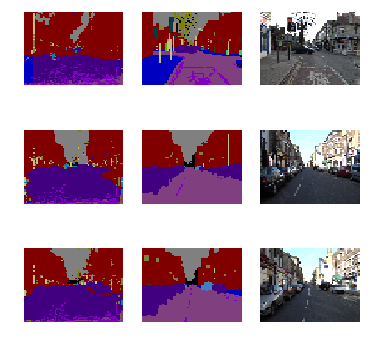

In [20]:
raw_features, raw_labels = get_next_minibatch(4)
e = z(raw_features)
e1 = decode_labels(e, num_classes).astype(np.uint8)
l1 = decode_labels(raw_labels, num_classes).astype(np.uint8)
tile_rgb_images(e1, l1, raw_features, row=3, col=3)